In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

### Priprava podatkov

In [3]:
lj_dez = pd.read_csv("../ljubljana_dez_2010_2023.csv")
# display(lj_dez)

data = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_21576\713682680.py:4: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


In [4]:
# Nastavljanje pravilnega časovnega pasu
lj_dez['NastanekDatumCas'] = pd.to_datetime(lj_dez['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_dez['NastanekDatumCas'] = lj_dez['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {lj_dez['NastanekDatumCas'].dtype}")

# data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')
# print(f"NastanekDatumCas column dtype: {data['NastanekDatumCas'].dtype}")

# display(lj_dez)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy

Preverila bom, če se ritmičnost nesreč, ki so se zgodile v dežju, razlikuje od ritmičnosti nesreč, ki so se zgodile v lepem vremenu. Za nesreče v dežju bom upoštevala vse nesreče, pri katerih je količina padlega dežja vsaj 1.0 mm/h.

In [5]:
# Maska za dež
rain_mask = (lj_dez['SkupenDez'] >= 1.0)

lj_dez = lj_dez[rain_mask]
# display(lj_dez)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = lj_dez['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsRain",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

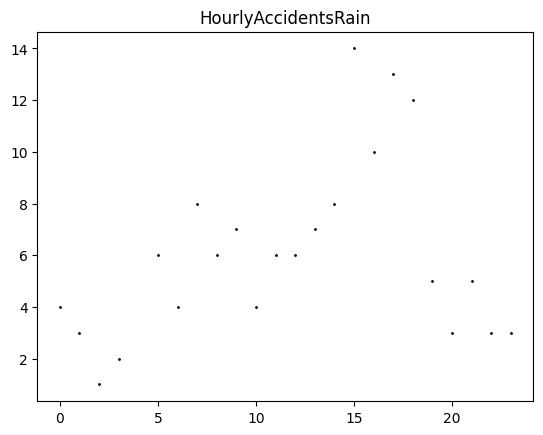

In [6]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsRain"])

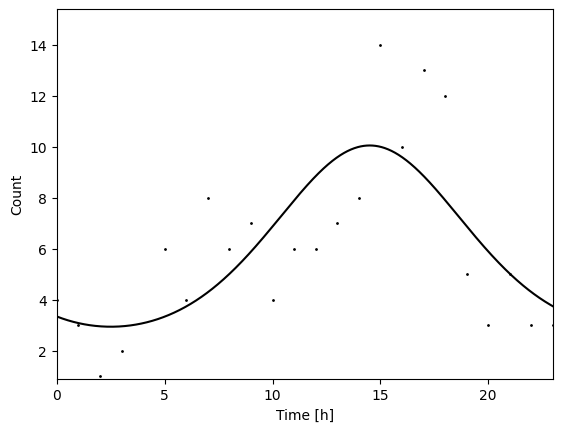

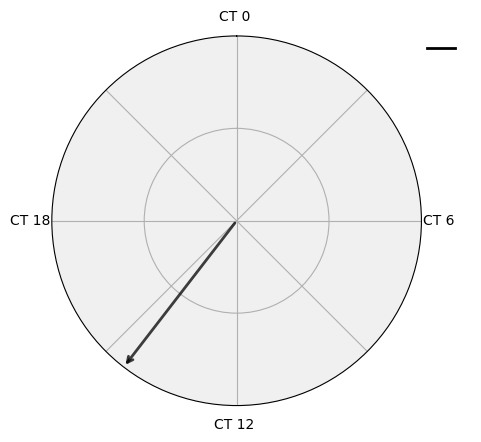

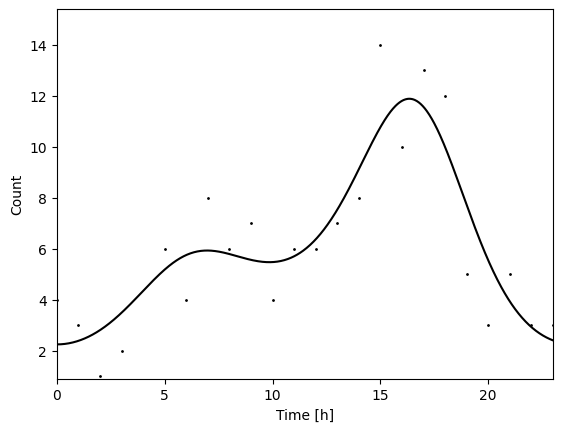

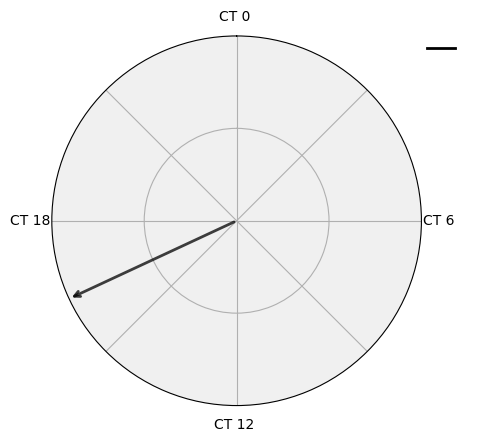

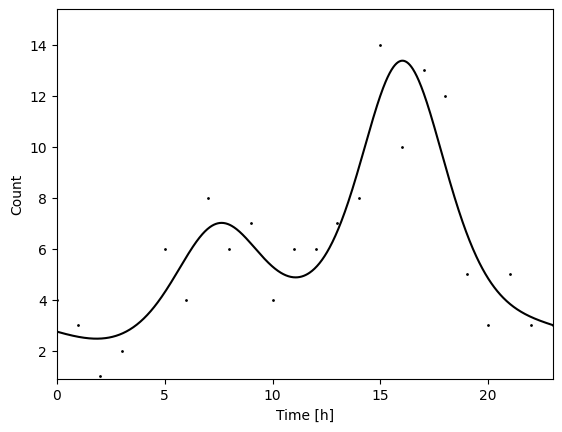

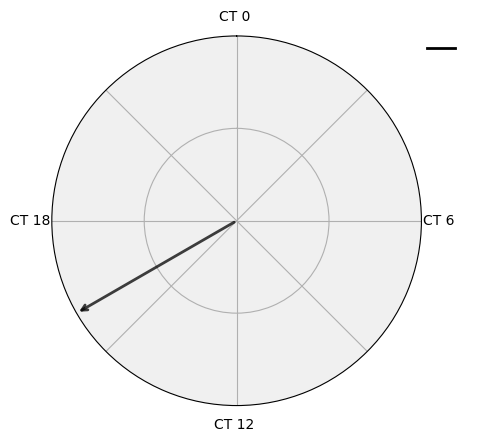

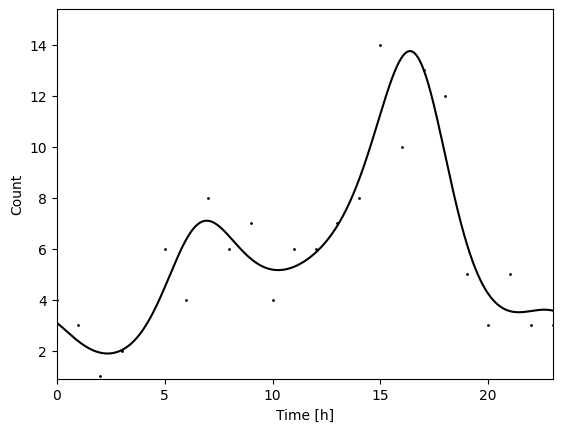

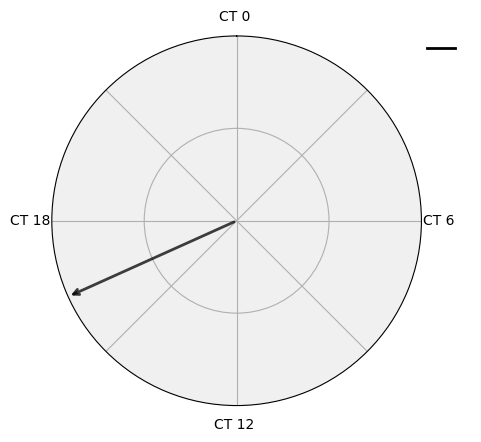

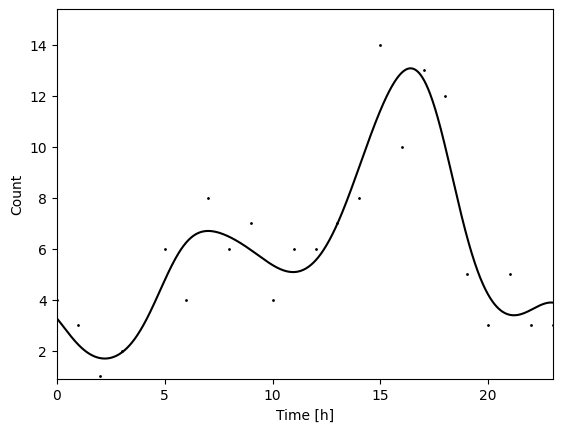

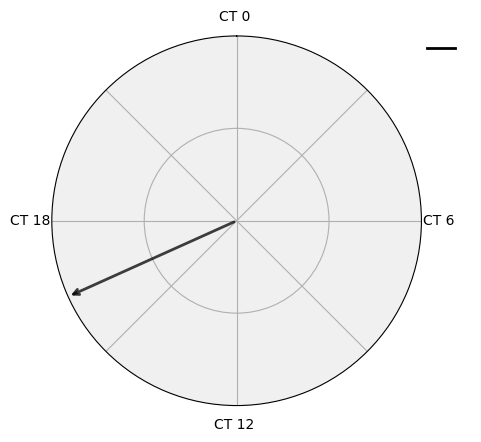

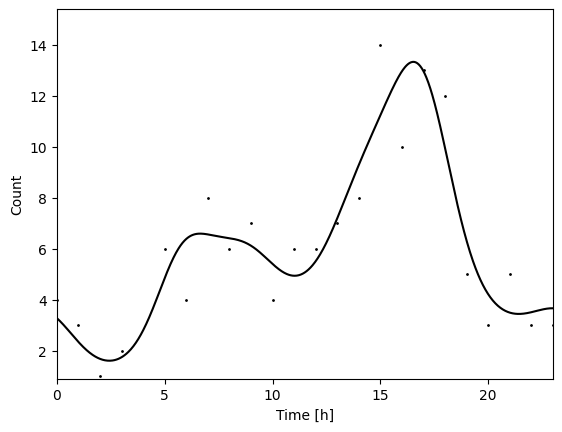

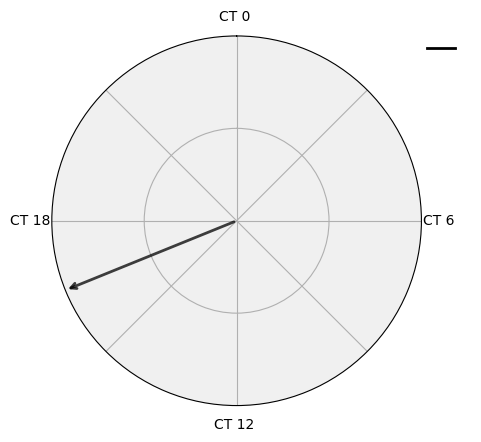

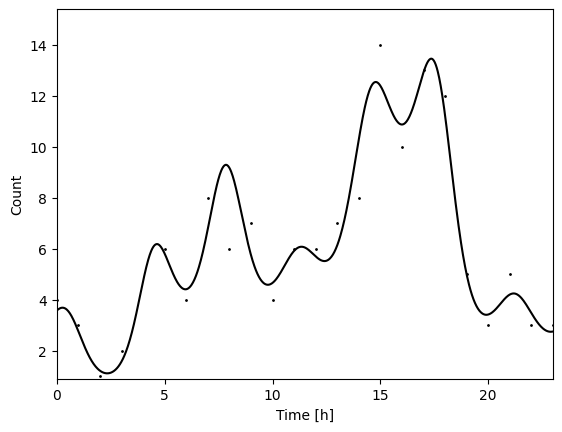

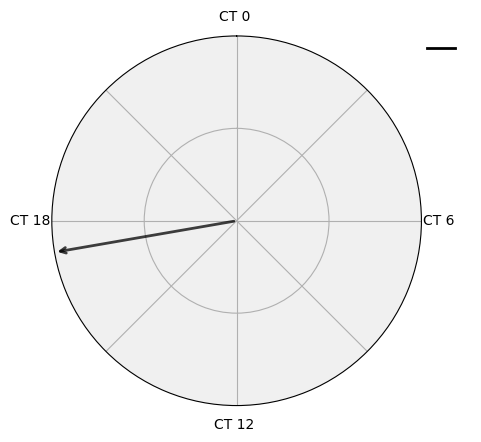

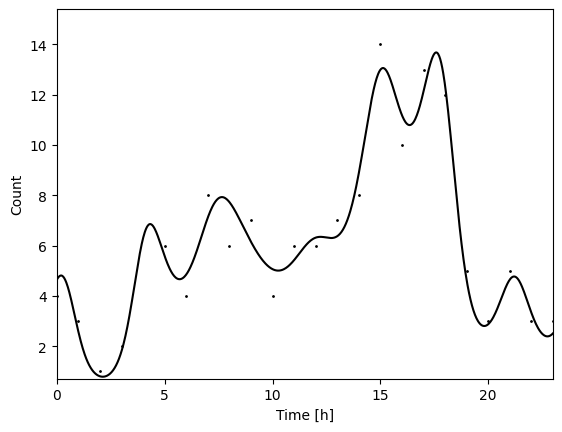

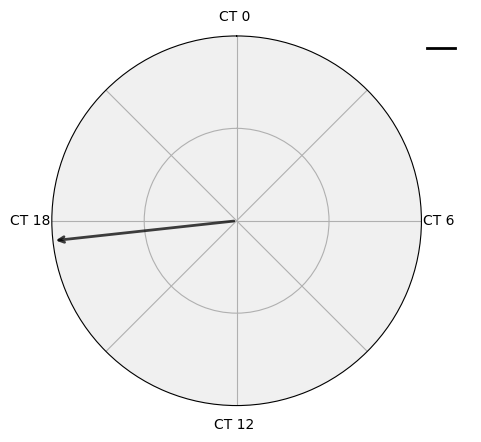

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


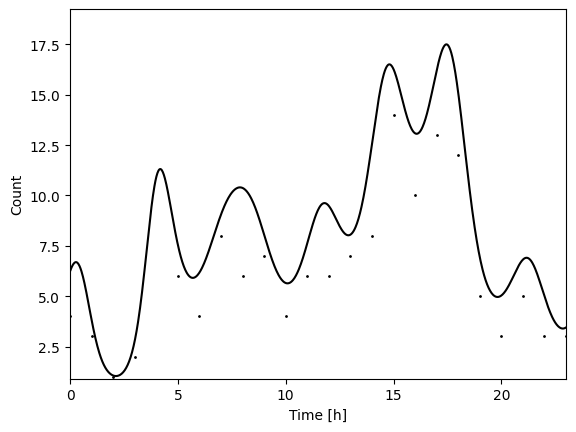

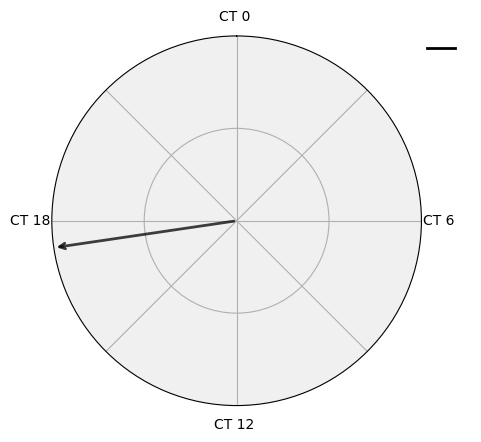

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


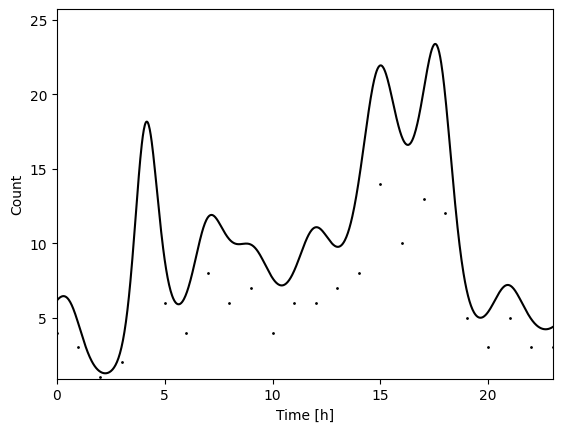

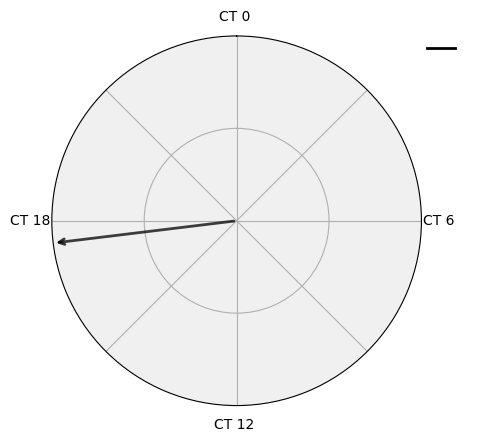

In [7]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsRain', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [8]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsRain,24.0,1.0,1.191801e-04,1.191801e-04,123.194895,-49.708661,0.153802,3.555361,2.484343,6.495494,[14.51051051051051],[10.050854612698409],[2.4984984984984986],[2.940132577483819]
1,HourlyAccidentsRain,24.0,2.0,1.337911e-06,1.911302e-06,58.162707,-42.363832,0.278834,4.818082,2.006342,7.065176,[16.336336336336338],[11.883258421284555],[9.84984984984985],[5.472274341980982]
2,HourlyAccidentsRain,24.0,3.0,6.146963e-07,1.229393e-06,48.987322,-39.074980,0.334821,5.452786,2.094395,7.924087,[16.0],[13.376120024300961],"[1.8258258258258258, 11.05105105105105]","[2.4713139540952516, 4.875867707028069]"
3,HourlyAccidentsRain,24.0,4.0,1.020132e-06,1.700221e-06,46.166052,-37.416089,0.363060,5.932138,1.993764,7.820978,[16.384384384384383],[13.753116262644578],"[2.354354354354354, 10.282282282282281, 21.429...","[1.8888395013634458, 5.161449338095514, 3.5085..."
4,HourlyAccidentsRain,24.0,5.0,3.739811e-06,4.674764e-06,42.042530,-36.897958,0.371881,5.693067,1.993764,7.384631,[16.384384384384383],[13.077542270640237],"[2.21021021021021, 10.954954954954955, 21.1891...","[1.6915639571979189, 5.083699029213235, 3.3891..."
5,HourlyAccidentsRain,24.0,6.0,1.513403e-05,1.681558e-05,43.344379,-36.732003,0.374706,5.862467,1.956027,7.468657,[16.52852852852853],[13.331123892481349],"[2.4504504504504503, 11.003003003003004, 21.42...","[1.6063136604351065, 4.939589365087538, 3.4420..."
6,HourlyAccidentsRain,24.0,7.0,4.738321e-08,1.184580e-07,25.355701,-27.625530,0.529726,6.172085,1.742185,7.283035,"[7.831831831831832, 14.7987987987988, 17.34534...","[9.291401619725363, 12.541036125420787, 13.454...","[2.354354354354354, 5.957957957957958, 9.80180...","[1.1113519991940668, 4.407649805777003, 4.5864..."
7,HourlyAccidentsRain,24.0,8.0,8.491484e-10,2.830495e-09,12.755565,-20.717266,0.647327,6.444096,1.679290,7.234052,"[7.63963963963964, 15.135135135135135, 17.5855...","[7.929287706024895, 13.057721965307246, 13.678...","[2.114114114114114, 5.66966966966967, 10.28228...","[0.7899643280772433, 4.66672403746634, 5.00790..."
8,HourlyAccidentsRain,24.0,9.0,0.000000e+00,0.000000e+00,124.063918,906.336827,16.428707,8.235716,1.717027,9.268366,"[4.18018018018018, 7.87987987987988, 11.819819...","[11.31280785545735, 10.403126657617491, 9.6209...","[2.114114114114114, 5.66966966966967, 10.09009...","[1.0328938120064894, 5.91001059398431, 5.63645..."
9,HourlyAccidentsRain,24.0,10.0,0.000000e+00,0.000000e+00,402.433273,909.776671,16.487264,11.057017,1.691869,12.320534,"[4.18018018018018, 14.99099099099099, 17.53753...","[18.158640851897733, 21.932301668534954, 23.37...","[2.2582582582582584, 5.621621621621622, 8.4564...","[1.263809170442061, 5.8994836374207456, 9.9317..."


### Katero je najboljše število komponent

In [9]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsRain,24.0,2.0,0.000001,0.000002,58.162707,-42.363832,0.278834,4.818082,2.006342,7.065176,[16.336336336336338],[11.883258421284555],[9.84984984984985],[5.472274341980982]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


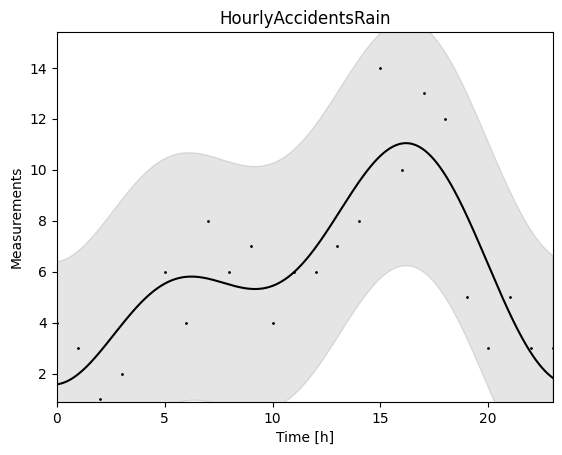

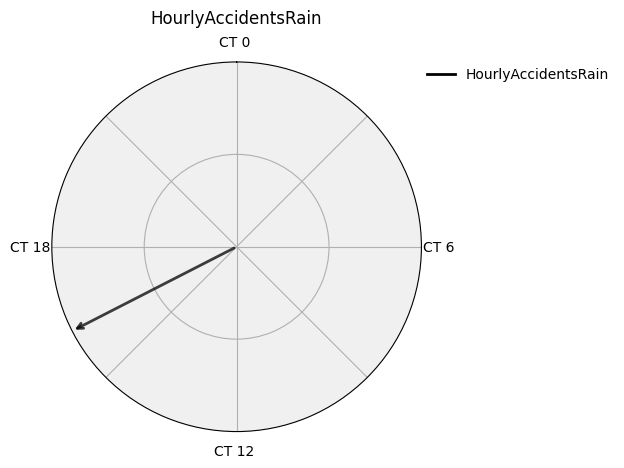

In [10]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [11]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsRain",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [12]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or 

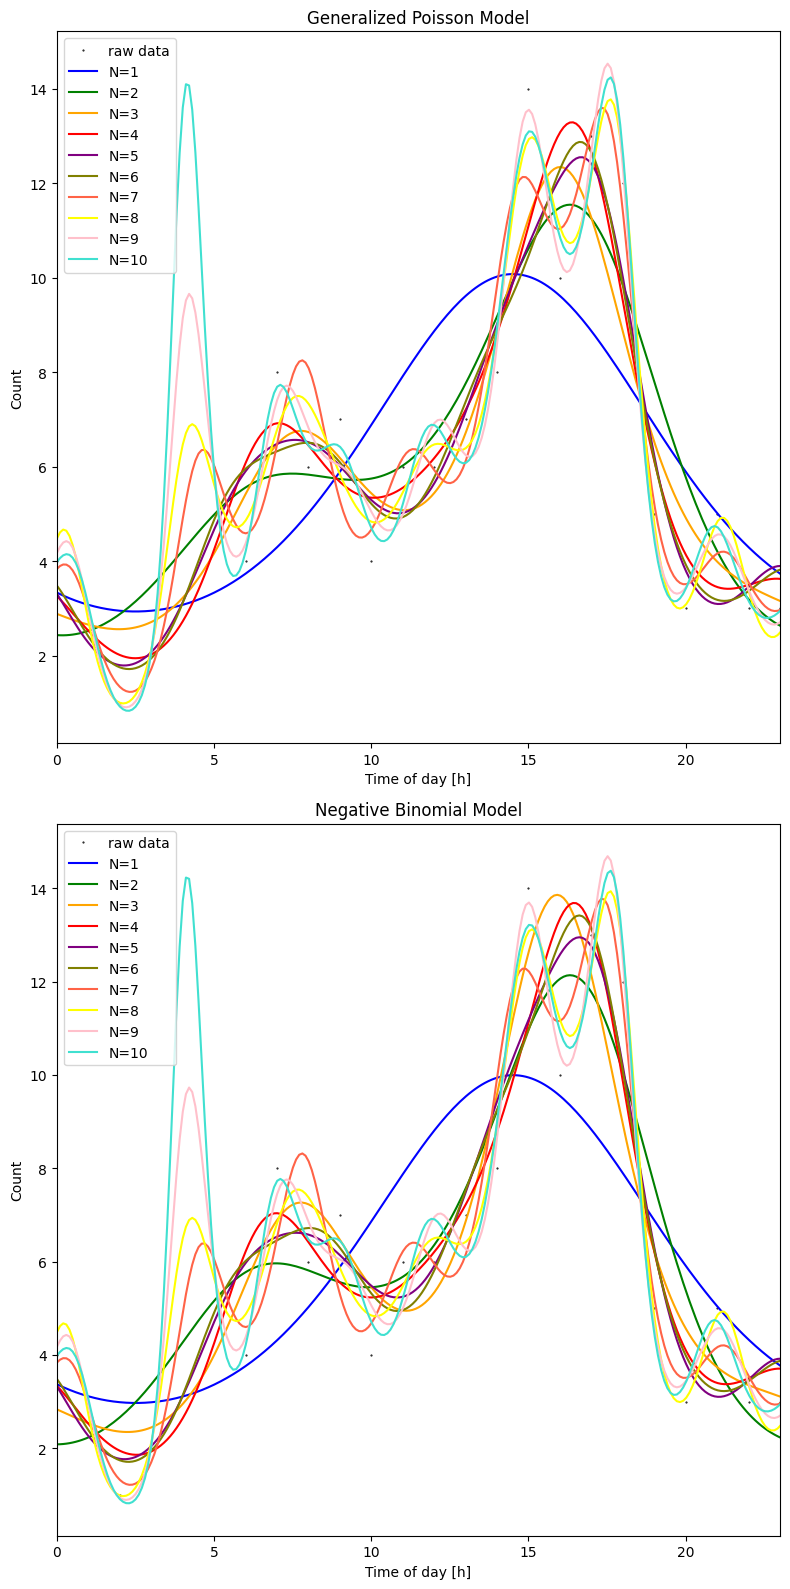

In [15]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [16]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,3.57,6.50,[14.51],[10.07],0.000119,123.236935,107.417820,111.959797,-49.708910,"[-1.6047714288719428, -1.4135067028964952, -1....",6.090237,"[3.331623492096714, 3.0736383105279415, 2.9479...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[3.331623492096714, 3.299529171152021, 3.26886..."
1,gen_poisson,2,4.56,6.98,[16.32],[11.54],0.000006,61.331229,100.055598,106.868563,-44.027799,"[-1.9789881242561336, -1.3625134423861245, -1....",6.147317,"[2.432064768527344, 2.522234612234292, 2.87553...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[2.432064768527344, 2.428661534026901, 2.42810..."
2,gen_poisson,3,4.89,7.45,[16.02],[12.34],0.000010,50.509075,100.302156,109.386110,-42.151078,"[-1.6706036833964664, -1.3293022226898974, -1....",5.959623,"[2.881470875572202, 2.653202251113805, 2.55751...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[2.881470875572202, 2.8556072174179272, 2.8301..."
3,gen_poisson,4,5.67,7.61,[16.42],[13.28],0.000045,44.840074,103.738624,115.093566,-41.869312,"[-1.5800594299073203, -1.3997529166732612, -1....",6.060114,"[3.2555237668778165, 2.524914589654608, 2.0119...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[3.2555237668778165, 3.1892619821945765, 3.119..."
4,gen_poisson,5,5.38,7.17,[16.72],[12.55],0.000191,40.913774,107.576609,121.202540,-41.788305,"[-1.577378344808782, -1.4764453099760155, -1.1...",5.948972,"[3.3090409685318796, 2.272154932212433, 1.7962...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[3.3090409685318796, 3.20228869209715, 3.09250..."
5,gen_poisson,6,5.58,7.29,[16.62],[12.87],0.000697,42.705620,111.578453,127.475372,-41.789227,"[-1.54829813982206, -1.4394461421840474, -1.16...",5.964531,"[3.479887748346577, 2.405039472641314, 1.75015...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[3.479887748346577, 3.386469569655488, 3.28573..."
6,gen_poisson,7,6.18,7.41,"[14.81, 17.32]","[12.13, 13.59]",0.000530,21.366861,111.542510,129.710418,-39.771255,"[-1.5212853859249025, -1.3833567853510385, -0....",6.086957,"[3.8342172262206486, 2.9401618388186725, 1.338...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[3.8342172262206486, 3.895172755730801, 3.9268..."
7,gen_poisson,8,6.39,7.38,"[15.12, 17.62]","[12.97, 13.77]",0.000911,11.912787,113.955450,134.394346,-38.977725,"[-1.567047668057986, -1.3890083298243852, -0.8...",6.086957,"[4.477282923050268, 2.7377059655240337, 1.0000...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[4.477282923050268, 4.607897453807632, 4.66583..."
8,gen_poisson,9,6.81,7.71,"[15.02, 17.52]","[13.55, 14.53]",0.002007,7.429954,117.361465,140.071349,-38.680732,"[-1.5310067601869144, -1.3837029768956723, -0....",6.086957,"[4.168947809214027, 2.9583626714723312, 0.9522...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[4.168947809214027, 4.302686727691396, 4.39089..."
9,gen_poisson,10,6.70,7.53,"[4.1, 15.02, 17.62]","[14.09, 13.09, 14.23]",0.004407,7.503609,121.058371,146.039244,-38.529185,"[-1.521420496178309, -1.388387054249133, -0.88...",6.086957,"[3.9801168053069342, 3.065719107038254, 0.9221...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[3.9801168053069342, 4.062817212473832, 4.1205..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [17]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 2


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [18]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 2
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

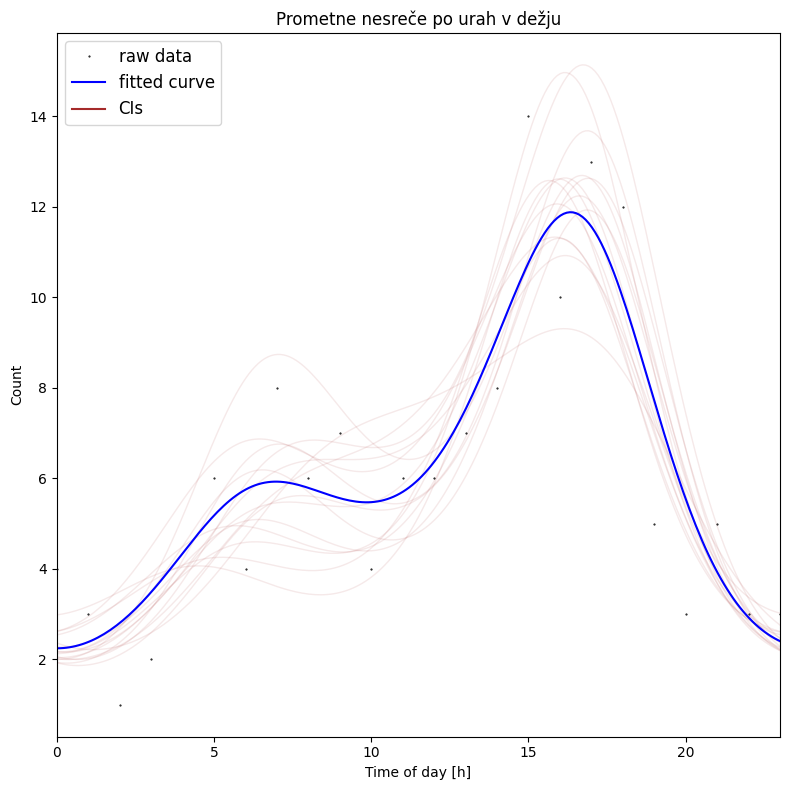

Intervali zaupanja:


,0,1
0,1.570335,1.776710
1,-0.462018,-0.112953
2,-0.684030,-0.338191
3,-0.069203,0.287391
4,-0.484942,-0.190108
5,-0.560582,-0.287666


In [22]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah v dežju', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [21]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,2
amplitude,4.56
mesor,6.98
peaks,[16.32]
heights,[11.54]
amplitude_CIs,"[2.88, 6.29]"
mesor_CIs,"[5.27, 8.41]"
peaks_CIs,"[15.05, 17.45]"
heights_CIs,"[8.2, 14.65]"
